In [1]:
import os

import pandas as pd
%matplotlib inline

import ukpopulation.utils as ukpoputils
import ukpopulation.snhpdata as SNHPData

/Users/will2/miniconda3/envs/smif/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The backend.qt4 rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1. In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


# Read in the raw data

In [2]:
data_path = os.path.join('.', 'data_as_provided')
output_path = os.path.join('.', 'data_processed')

baseline_file = os.path.join(data_path, 'Scenario Baseline - Dwelling+Employment projections.xlsx')
expansion_file = os.path.join(data_path, 'Scenario Expansion - Dwelling+Employment projections.xlsx')
settlements_file = os.path.join(data_path, 'Scenario New Settlements - Dwelling+Employment projections.xlsx')
unplanned_file = os.path.join(data_path, 'Scenario Unplanned Development - Dwelling+Employment projections.xlsx')

In [3]:
def get_households(year, geogs, df): 
    """Use UKPopulation to obtain historical and extrapolated household data for all other LADs
    
    Arguments
    ---------
    year : int
    geogs : list
    df : pandas.DataFrame
        The raw data
    
    Returns
    -------
    pandas.DataFrame
    """

    geogs = ukpoputils.split_by_country(geogs)

    allsnhp = pd.DataFrame()

    for country in geogs:
        if not geogs[country]: continue
        max_year = df.max_year(country)
        min_year = df.min_year(country)

        if year <= max_year:
            if year <= min_year:
                snhp = df.aggregate(geogs[country], min_year+1).merge(
                            df.aggregate(geogs[country], min_year), 
                            left_on="GEOGRAPHY_CODE", right_on="GEOGRAPHY_CODE")
                snhp["HOUSEHOLDS"] = snhp.OBS_VALUE_y + (snhp.OBS_VALUE_y - snhp.OBS_VALUE_x) * (min_year - year)
                snhp["PROJECTED_YEAR_NAME"] = year
                snhp.drop(["PROJECTED_YEAR_NAME_x", "OBS_VALUE_x", "PROJECTED_YEAR_NAME_y", "OBS_VALUE_y"], axis=1, inplace=True)
            else:
                snhp = df.aggregate(geogs[country], year).rename({"OBS_VALUE": "HOUSEHOLDS"}, axis=1)
        else:
            snhp = df.aggregate(
                geogs[country], max_year-1).merge(
                df.aggregate(geogs[country], max_year), 
                left_on="GEOGRAPHY_CODE", right_on="GEOGRAPHY_CODE")
            snhp["HOUSEHOLDS"] = snhp.OBS_VALUE_y + (snhp.OBS_VALUE_y - snhp.OBS_VALUE_x) * (year - max_year)
            snhp["PROJECTED_YEAR_NAME"] = year
            snhp.drop(["PROJECTED_YEAR_NAME_x", "OBS_VALUE_x", "PROJECTED_YEAR_NAME_y", "OBS_VALUE_y"], axis=1, inplace=True)

        allsnhp = allsnhp.append(snhp, ignore_index=True, sort=False)

    return allsnhp

def read_excel_into_df(filename, sheet_name):
    
    years = [str(x) for x in range(2004, 2050)]
    types = {str(year): int for year in years}
    
    return pd.read_excel(
        filename, 
        sheet_name=sheet_name, 
        header=3, 
        index_col=0,
        names=['Area Name'].extend(years),
        nrows=22,
        dtype=types
    )

def process_df(df):
    df = df.dropna(
        ).reset_index(
        ).melt(
            id_vars='Area Name',
            var_name='timestep',
            value_name='dwellings')
    df = df.set_index(['Area Name', 'timestep'])
    return df

lad_nmcds = pd.read_csv(os.path.join(data_path, 'lad_nmcd_changes.csv'))
lad_nmcds = lad_nmcds[['lad16nm', 'lad16cd']]
all_lad_nms = set(lad_nmcds.lad16nm)

def add_national_data(df, lad_nmcds, snhp):
    all_lads = set(lad_nmcds['lad16cd'])
    arc_lads = set(df.reset_index()['lad16cd'].unique())
    required_lads = all_lads - arc_lads

    years = list(df['timestep'].unique())
    for year in years:
        national_data = get_households(year, required_lads, snhp)
        national_data = national_data.rename(columns={'GEOGRAPHY_CODE': 'lad16cd',
                                      'PROJECTED_YEAR_NAME': 'timestep',
                                      'HOUSEHOLDS': 'dwellings'})
        df = df.append(national_data)
    return df

def add_lad_codes(df):

    baseline_lad_nms = set(df.reset_index()['Area Name'].unique())
    df_wlad = df.reset_index().merge(lad_nmcds, 
                                     left_on='Area Name', 
                                     right_on='lad16nm').drop(columns='Area Name')
    return df_wlad

def write_out(df, filename):
    df.to_csv(os.path.join(output_path, filename), index=False)

In [4]:
baseline = read_excel_into_df(baseline_file, 'Projection dwelling baseline')
expansion = read_excel_into_df(expansion_file, 'Projection Expansion data')
settlements = read_excel_into_df(settlements_file, 'Projection New Settlem data')
unplanned = read_excel_into_df(unplanned_file, 'Projection UnplannedDev')

arc_lads = set(baseline.reset_index()['Area Name'].unique())

baseline = process_df(baseline)
expansion = process_df(expansion)
settlements = process_df(settlements)
unplanned = process_df(unplanned)

baseline = add_lad_codes(baseline)
expansion = add_lad_codes(expansion)
settlements = add_lad_codes(settlements)
unplanned = add_lad_codes(unplanned)

snhp = SNHPData.SNHPData()

baseline = add_national_data(baseline, lad_nmcds, snhp)
expansion = add_national_data(expansion, lad_nmcds, snhp)
settlements = add_national_data(settlements, lad_nmcds, snhp)
unplanned = add_national_data(unplanned, lad_nmcds, snhp)

write_out(baseline, 'baseline.csv')
write_out(expansion, 'expansion.csv')
write_out(settlements, 'settlements.csv')
write_out(unplanned, 'unplanned.csv')

Collating SNHP data for England...
Collating SNHP data for Wales...
Collating SNHP data for Scotland...
Collating SNHP data for Northern Ireland...


/Users/will2/miniconda3/envs/smif/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## Check the data

In [5]:
def filter_on_arc(df, lad_nmcds, arc_lads):
    
    df = df.reset_index()
    
    just_arc_lads = df.lad16cd.isin(lad_nmcds[lad_nmcds.lad16nm.isin(arc_lads)].lad16cd)
    
    df = df[just_arc_lads]
    df = df.set_index(['timestep', 'lad16cd'])
    return df

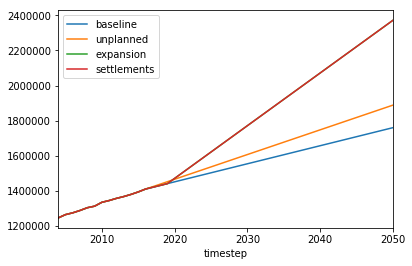

In [6]:
bas = filter_on_arc(baseline, lad_nmcds, arc_lads)
bas['unplanned'] = filter_on_arc(unplanned, lad_nmcds, arc_lads)['dwellings']
bas['expansion'] = filter_on_arc(expansion, lad_nmcds, arc_lads)['dwellings']
bas['settlements'] = filter_on_arc(settlements, lad_nmcds, arc_lads)['dwellings']
bas.rename(columns={'dwellings': 'baseline'}).drop(columns=['index']).groupby(
    by='timestep').sum().plot()

In [11]:
"Number of LADs in data: {}".format(len(baseline.lad16cd.unique()))

'Number of LADs in data: 380'